# ***目标检测***

① 前两节课程中，我们介绍的是利用CNN模型进行图像分类。

② 除此之外，本周课程将继续深入介绍目标定位和目标检测（包含多目标检测）。

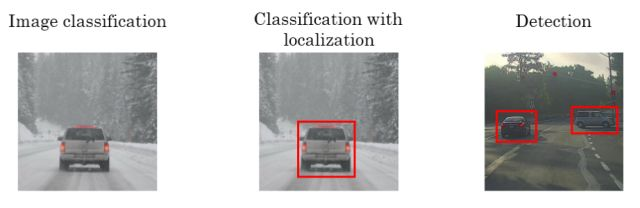

# 1. 目标定位卷积输出

① 标准的CNN分类模型我们已经很熟悉了，如下所示。

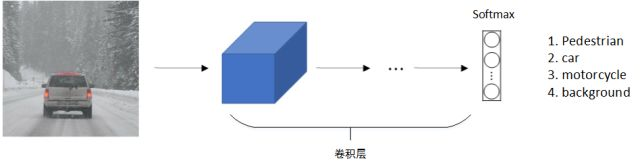

② 原始图片经过CONV卷积层后，Softmax层输出4 x 1向量，分别是：

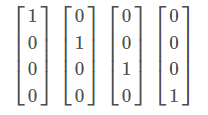

③ 注意，class label也可能是概率。上述四个向量分别对应pedestrain，car，motorcycle和background四类。

① 对于目标定位和目标检测问题，其模型如下所示。

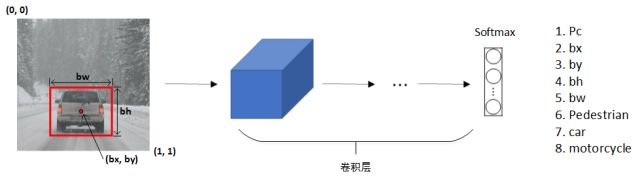

② 原始图片经过CONV卷积层后，Softmax层输出8 x 1向量。

③ 除了包含上述一般CNN分类3 x 1向量（class label）之外，还包含了(bx, by)，表示目标中心位置坐标；还包含了bh和bw，表示目标所在矩形区域的高和宽；还包含了Pc，表示矩形区域是目标的概率，数值在0～1之间，且越大概率越大。

④ 一般设定图片左上角为原点(0, 0)，右下角为(1, 1)。

⑤ 在模型训练时，bx、by、bh、bw都由人为确定其数值。例如上图中，可得bx=0.5，by=0.7，bh=0.3，bw=0.4。

① 输出label可表示为：

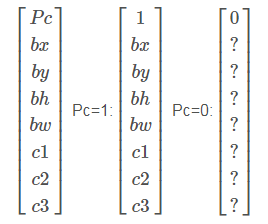

② 若Pc=0，表示没有检测到目标，则输出label后面的7个参数都可以忽略。

③ 对于损失函数Loss function，若使用平方误差形式，有两种情况：

④ Pc=1，即y1=1：

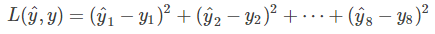

⑤ Pc=0，即y1=0：

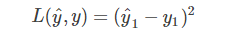

⑥ 当然，除了使用平方误差之外，还可以使用逻辑回归损失函数，类标签c1,c2,c3c1,c2,c3也可以通过softmax输出。

⑦ 比较而言，平方误差已经能够取得比较好的效果。

# 2. 关键点定位

① 除了使用矩形区域检测目标类别和位置外，我们还可以仅对目标的关键特征点坐标进行定位，这些关键点被称为landmarks。

② 例如人脸识别，可以对人脸部分特征点坐标进行定位检测，并标记出来，如下图所示。

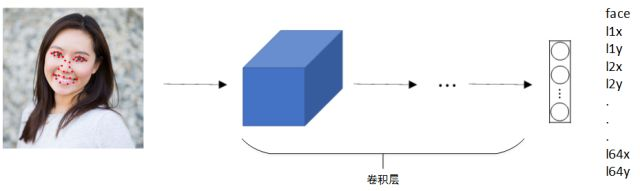

③ 该网络模型共检测人脸上64处特征点，加上是否为face的标志位，输出label共有64x2+1=129个值。

④ 通过检测人脸特征点可以进行情绪分类与判断，或者应用于AR领域等等。

⑤ 除了人脸特征点检测之外，还可以检测人体姿势动作，如下图所示。

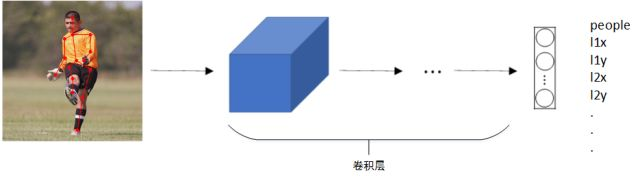

# 3. 目标检测滑动窗口

① 目标检测的一种简单方法是滑动窗算法。

② 这种算法首先在训练样本集上搜集相应的各种目标图片和非目标图片。

③ 注意训练集图片尺寸较小，尽量仅包含相应目标，如下图所示。

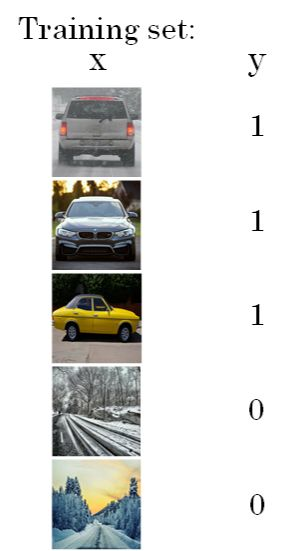

④ 然后，使用这些训练集构建CNN模型，使得模型有较高的识别率。

⑤ 最后，在测试图片上，选择大小适宜的窗口、合适的步进长度，进行从左到右、从上倒下的滑动。

⑥ 每个窗口区域都送入之前构建好的CNN模型进行识别判断。

⑦ 若判断有目标，则此窗口即为目标区域；若判断没有目标，则此窗口为非目标区域。

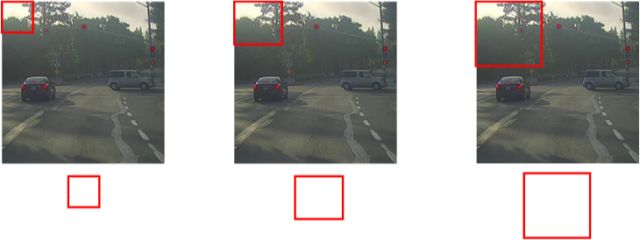

① 滑动窗算法的优点是原理简单，且不需要人为选定目标区域（检测出目标的滑动窗即为目标区域）。

② 但是其缺点也很明显，首先滑动窗的大小和步进长度都需要人为直观设定。

③ 滑动窗过小或过大，步进长度过大均会降低目标检测正确率。

④ 而且，每次滑动窗区域都要进行一次CNN网络计算，如果滑动窗和步进长度较小，整个目标检测的算法运行时间会很长。

⑤ 所以，滑动窗算法虽然简单，但是性能不佳，不够快，不够灵活。

① 滑动窗算法可以使用卷积方式实现，以提高运行速度，节约重复运算成本。

② 首先，单个滑动窗口区域进入CNN网络模型时，包含全连接层。

③ 那么滑动窗口算法卷积实现的第一步就是将全连接层转变成为卷积层，如下图所示。

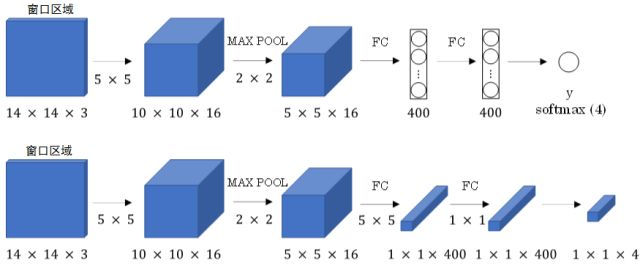

④ 全连接层转变成卷积层的操作很简单，只需要使用与上层尺寸一致的滤波算子进行卷积运算即可。

⑤ 最终得到的输出层维度是1 x 1 x 4，代表4类输出值。

⑥ 单个窗口区域卷积网络结构建立完毕之后，对于待检测图片，即可使用该网络参数和结构进行运算。

⑦ 例如16 x 16 x 3的图片，步进长度为2，CNN网络得到的输出层为2 x 2 x 4。其中，2 x 2表示共有4个窗口结果。

⑧ 对于更复杂的28 x 28 x3的图片，CNN网络得到的输出层为8 x 8 x 4，共64个窗口结果。

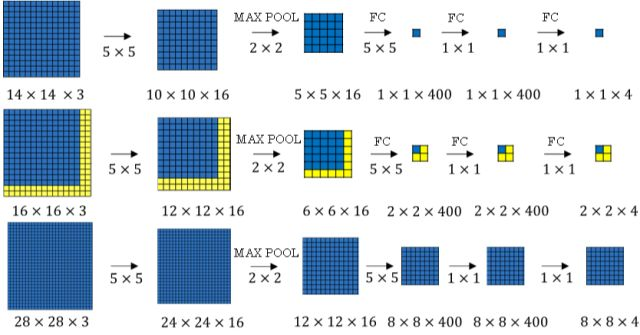

⑨ 之前的滑动窗算法需要反复进行CNN正向计算，例如16 x 16 x 3的图片需进行4次，28 x 28 x3的图片需进行64次。而利用卷积操作代替滑动窗算法，则不管原始图片有多大，只需要进行一次CNN正向计算，因为其中共享了很多重复计算部分，这大大节约了运算成本。

⑩ 值得一提的是，窗口步进长度与选择的MAX POOL大小有关。如果需要步进长度为4，只需设置MAX POOL为4 x 4即可。

① 滑动窗口算法有时会出现滑动窗不能完全涵盖目标的问题，如下图蓝色窗口所示。

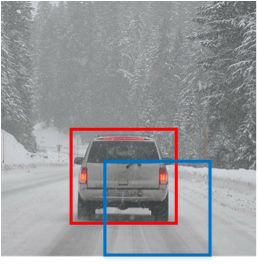

② YOLO（You Only Look Once）算法可以解决这类问题，生成更加准确的目标区域（如上图红色窗口）。

③ YOLO算法首先将原始图片分割成n x n网格，每个网格代表一块区域。为简化说明，下图中将图片分成3 x 3网格。

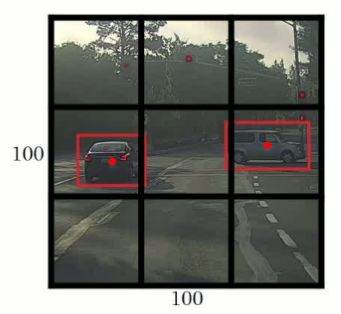

④ 然后，利用上一节卷积形式实现滑动窗口算法的思想，对该原始图片构建CNN网络，得到的的输出层维度为3 x 3 x 8。其中，3 x 3对应9个网格，每个网格的输出包含8个元素：

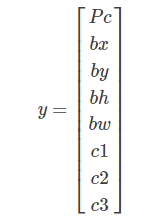

⑤ 如果目标中心坐标(bx,by)不在当前网格内，则当前网格Pc=0；相反，则当前网格Pc=1（即只看中心坐标是否在当前网格内）。

⑥ 判断有目标的网格中，bx,by,bh,bw限定了目标区域。值得注意的是，当前网格左上角坐标设定为(0, 0)，右下角坐标设定为(1, 1)，(bx,by)范围限定在[0,1]之间，但是bh,bw可以大于1。

⑦ 因为目标可能超出该网格，横跨多个区域，如上图所示。目标占几个网格没有关系，目标中心坐标必然在一个网格之内。

⑧ 划分的网格可以更密一些。网格越小，则多个目标的中心坐标被划分到一个网格内的概率就越小，这恰恰是我们希望看到的。

# 4. 交并比IoU

① IoU，即交集与并集之比，可以用来评价目标检测区域的准确性。

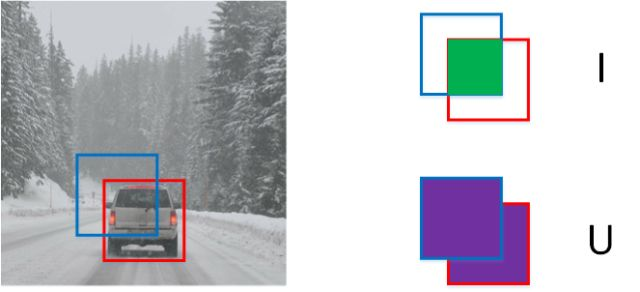

② 如上图所示，红色方框为真实目标区域，蓝色方框为检测目标区域。

③ 两块区域的交集为绿色部分，并集为紫色部分。蓝色方框与红色方框的接近程度可以用IoU比值来定义：

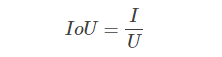

④ IoU可以表示任意两块区域的接近程度。IoU值介于0～1之间，且越接近1表示两块区域越接近。

# 5. 非最大值抑制NMS

① YOLO算法中，可能会出现多个网格都检测出到同一目标的情况，例如几个相邻网格都判断出同一目标的中心坐标在其内。

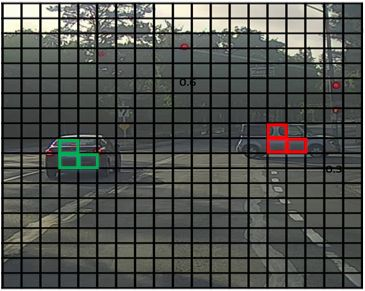

② 上图中，三个绿色网格和三个红色网格分别检测的都是同一目标。那如何判断哪个网格最为准确呢？方法是使用非最大值抑制算法。

③ 非最大值抑制（Non-max Suppression）做法很简单，图示每个网格的Pc值可以求出，Pc值反映了该网格包含目标中心坐标的可信度。

④ 首先选取Pc最大值对应的网格和区域，然后计算该区域与所有其它区域的IoU，剔除掉IoU大于阈值（例如0.5）的所有网格及区域。这样就能保证同一目标只有一个网格与之对应，且该网格Pc最大，最可信。

⑤ 接着，再从剩下的网格中选取Pc最大的网格，重复上一步的操作。

⑥ 最后，就能使得每个目标都仅由一个网格和区域对应，如下图所示。

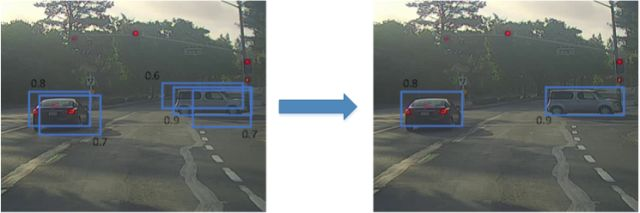

⑧ 总结一下非最大值抑制算法的流程：

 - 剔除Pc值小于某阈值（例如0.6）的所有网格；
 - 选取Pc值最大的网格，利用IoU，摒弃与该网格交叠较大的网格；
 - 对剩下的网格，重复步骤2。

# 6. Anchor Boxes

① 到目前为止，我们介绍的都是一个网格至多只能检测一个目标。

② 那对于多个目标重叠的情况，例如一个人站在一辆车前面，该如何使用YOLO算法进行检测呢？方法是使用不同形状的Anchor Boxes。

① 如下图所示，同一网格出现了两个目标：人和车。为了同时检测两个目标，我们可以设置两个Anchor Boxes，Anchor box 1检测人，Anchor box 2检测车。

② 也就是说，每个网格多加了一层输出。原来的输出维度是 3 x 3 x 8，现在是3 x 3 x 2 x 8（也可以写成3 x 3 x 16的形式）。这里的2表示有两个Anchor Boxes，用来在一个网格中同时检测多个目标。

③ 每个Anchor box都有一个Pc值，若两个Pc值均大于某阈值，则检测到了两个目标。

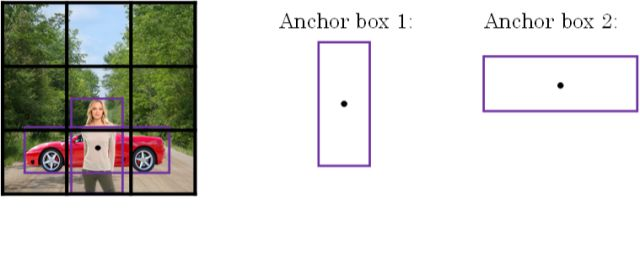

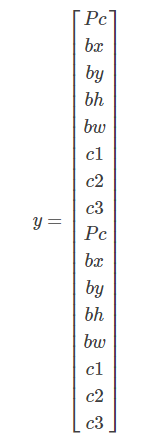

① 在使用YOLO算法时，只需对每个Anchor box使用上一节的非最大值抑制即可。Anchor Boxes之间并行实现。

② 顺便提一下，Anchor Boxes形状的选择可以通过人为选取，也可以使用其他机器学习算法，例如k聚类算法对待检测的所有目标进行形状分类，选择主要形状作为Anchor Boxes。

# 7. YOLO算法

① 这一节主要介绍YOLO算法的流程，算是对前几节内容的回顾。

② 网络结构如下图所示，包含了两个Anchor Boxes。

 - For each grid call, get 2 predicted bounding boxes.
 - Get rid of low probability predictions.
 - For each class (pedestrian, car, motorcycle) use non-max suppression to generate final predictions.

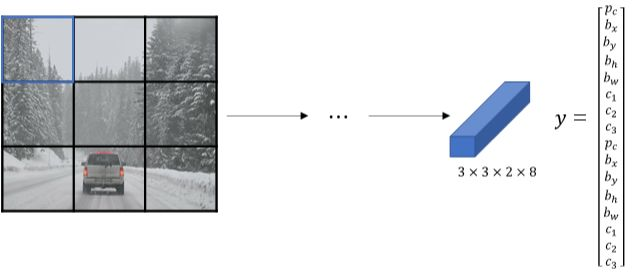

# 8. Region Proposals

① 之前介绍的滑动窗算法会对原始图片的每个区域都进行扫描，即使是一些空白的或明显没有目标的区域，例如下图所示。这样会降低算法运行效率，耗费时间。

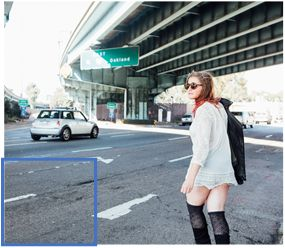

② 为了解决这一问题，尽量避免对无用区域的扫描，可以使用Region Proposals的方法。

③ 具体做法是先对原始图片进行分割算法处理，然后支队分割后的图片中的块进行目标检测。

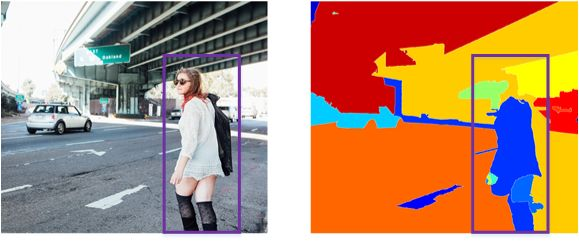

④ Region Proposals共有三种方法：

 - R-CNN: 滑动窗的形式，一次只对单个区域块进行目标检测，运算速度慢。
 - Fast R-CNN: 利用卷积实现滑动窗算法，类似第3节做法。
 - Faster R-CNN: 利用卷积对图片进行分割，进一步提高运行速度。
 
⑤ 比较而言，Faster R-CNN的运行速度还是比YOLO慢一些。